# Exploratory Data Analysis + Basic Modeling

### Context
We have sensors for a multistage chemical process that include information about temperatures, chemical flow rates, additive ratios, pressures, and blending ratios in various stages in the process. In a real situation, we would need to think about how molecules travel through a process and at what time they would have experienced the given process settings. This data set has already been preprocessed to "flatten" the mentioned time series elements, meaning all residence time effects have already been considered. The data is real production data and has some issues that we will have to explore and account for.

A simple diagram of our process:

![Process Diagram](https://i.imgur.com/4lPQtRn.jpg)

### Modeling Objective
Predict the parameter "Quality" given the sensor data.

## Load libraries, data

In [81]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
%matplotlib inline

# annoying warnings
import warnings
warnings.filterwarnings('ignore')

In [82]:
data = pd.read_csv("../../../datasets/anonymized_SAP_data.csv")
data.shape

(2709, 23)

In [83]:
data.head()

,Unnamed: 0,Date.Time,Main_Mass_Flow,Additive_1_Ratio,Additive_2_Ratio,Additive_3_Ratio,Additive_4_Ratio,Additive_5_Ratio,Additive_6_Ratio,Flow_Gas_Ratio,...,T_Zone_3,T_Zone_4,T_Zone_5,T_Zone_6,T_Zone_7,T_Zone_8,T_Zone_9,T_Zone_10,Blending,Quality
0,1543100,2017-01-01 02:42:00,17947.958984,0.000626,0.053146,0.000876,0.001,0.00091,0.00525,2.534770,...,197.865295,175.733353,177.881012,180.187149,175.288040,181.461487,184.349884,178.632538,24.0,45.0750
1,1601100,2017-01-01 03:40:00,17942.625000,0.000626,0.053146,0.000876,0.001,0.00091,0.00525,2.524599,...,198.242508,175.395889,176.092880,178.021576,173.222076,180.226273,183.611710,177.633362,24.0,44.6825
2,1670100,2017-01-01 04:49:00,17955.152344,0.000626,0.053146,0.000876,0.001,0.00091,0.00525,2.528997,...,197.993622,175.388733,176.331268,178.255264,173.343567,179.927109,183.406296,177.319366,24.0,44.2900
3,1709100,2017-01-01 05:28:00,17965.117188,0.000626,0.053146,0.000876,0.001,0.00091,0.00525,2.519700,...,198.104874,175.564926,175.403198,177.945908,172.337830,178.773697,182.526581,176.517807,24.0,44.4275
4,1768100,2017-01-01 06:27:00,17949.132812,0.000626,0.053146,0.000876,0.001,0.00091,0.00525,2.525926,...,197.611877,174.955109,174.076019,176.105621,170.777313,177.310883,181.188675,175.847260,24.0,44.5650


The first column is an index- we can take this out right away. The `Date.Time` column can be removed for numerical analysis, but this might inform about how we thing about sampling. We'll take it out of the dataframe, but keep it as an object in case we want it in the future.

In [84]:
dates = data['Date.Time']
data.drop(['Unnamed: 0', 'Date.Time'], axis = 1, inplace = True)
data.columns

Index(['Main_Mass_Flow', 'Additive_1_Ratio', 'Additive_2_Ratio',
       'Additive_3_Ratio', 'Additive_4_Ratio', 'Additive_5_Ratio',
       'Additive_6_Ratio', 'Flow_Gas_Ratio', 'Pressure', 'T_Zone_1',
       'T_Zone_2', 'T_Zone_3', 'T_Zone_4', 'T_Zone_5', 'T_Zone_6', 'T_Zone_7',
       'T_Zone_8', 'T_Zone_9', 'T_Zone_10', 'Blending', 'Quality'],
      dtype='object')

In [85]:
data.describe()

,Main_Mass_Flow,Additive_1_Ratio,Additive_2_Ratio,Additive_3_Ratio,Additive_4_Ratio,Additive_5_Ratio,Additive_6_Ratio,Flow_Gas_Ratio,Pressure,T_Zone_1,...,T_Zone_3,T_Zone_4,T_Zone_5,T_Zone_6,T_Zone_7,T_Zone_8,T_Zone_9,T_Zone_10,Blending,Quality
count,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.0,2709.000000,...,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000
mean,19168.710275,0.000682,0.070223,0.000887,0.002099,0.000943,0.004787,3.010484,0.0,151.532175,...,194.897517,173.547416,175.089547,177.951496,170.750994,177.066127,179.081815,170.588559,23.806458,45.184728
std,2607.298581,0.000029,0.010099,0.000039,0.000529,0.000034,0.001489,0.236815,0.0,82.796166,...,9.420607,8.133296,7.550519,5.579576,6.353755,6.824849,7.812618,9.526156,8.588359,1.886299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.150000
25%,18741.343750,0.000694,0.064253,0.000876,0.001886,0.000910,0.005250,2.991348,0.0,190.621689,...,194.995377,172.314590,173.772705,175.642105,168.236435,174.776779,177.085846,167.410660,25.000000,44.352500
50%,19285.621094,0.000694,0.070000,0.000876,0.002000,0.000971,0.005250,3.001231,0.0,197.830124,...,196.476089,174.674225,175.616089,178.171570,171.000046,177.444672,179.682465,172.029968,27.000000,45.300000
75%,20285.824219,0.000694,0.075882,0.000876,0.002000,0.000971,0.005250,3.015616,0.0,198.116196,...,197.932388,176.169693,177.434448,180.922363,174.568054,180.841415,182.661087,175.247818,28.000000,46.310000
max,21387.343750,0.000694,0.114304,0.001000,0.003500,0.000971,0.005250,4.474757,0.0,202.513199,...,209.552963,190.916901,203.776215,203.107742,199.561401,194.872360,189.870865,181.314682,28.000000,50.510000


In [86]:
# drop zero variance columns
data.drop(['Pressure'], axis = 1, inplace = True)

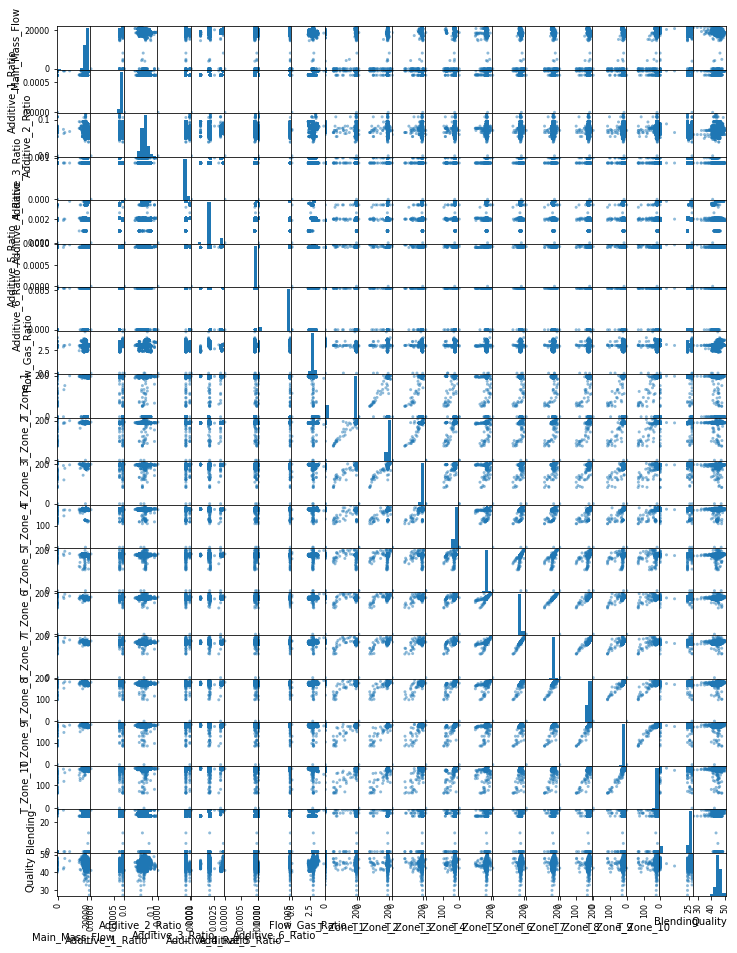

In [87]:
grr = pd.plotting.scatter_matrix(data, figsize = (12,16))

A few more targeted visuals to see the response of our quality to the ratios...

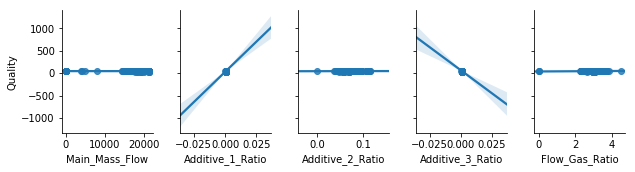

In [89]:
# visualize the relationship between the features and the response using scatterplots
sns.pairplot(data, x_vars=['Main_Mass_Flow','Additive_1_Ratio','Additive_2_Ratio','Additive_3_Ratio','Flow_Gas_Ratio'], y_vars='Quality', aspect=0.7, kind='reg')

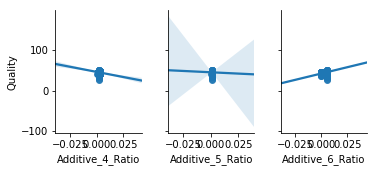

In [92]:
# visualize the relationship between the features and the response using scatterplots
sns.pairplot(data, x_vars=['Additive_4_Ratio','Additive_5_Ratio','Additive_6_Ratio'], 
             y_vars='Quality', aspect=0.7, kind='reg')

Okay... so far, nothing is popping out. Need to do some more univariate analysis, combined with a little bit of reality checks on our values.

All the ratios are calculated off of the main mass flow, so this will end up being an important variable one way or another. Let's start investigating here.

(array([ 39.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   5.,   1.,   4.,   6.,  49.,  33., 198., 127., 262.,
        346., 443., 322., 295., 450., 123.]),
 array([    0.      ,   427.746875,   855.49375 ,  1283.240625,
         1710.9875  ,  2138.734375,  2566.48125 ,  2994.228125,
         3421.975   ,  3849.721875,  4277.46875 ,  4705.215625,
         5132.9625  ,  5560.709375,  5988.45625 ,  6416.203125,
         6843.95    ,  7271.696875,  7699.44375 ,  8127.190625,
         8554.9375  ,  8982.684375,  9410.43125 ,  9838.178125,
        10265.925   , 10693.671875, 11121.41875 , 11549.165625,
        11976.9125  , 12404.659375, 12832.40625 , 13260.153125,
        13687.9     , 14115.646875, 14543.39375 , 14971.140625,
        15398.8875  , 15826.634375, 16254.38125 , 16682.128125,
        17109.875 

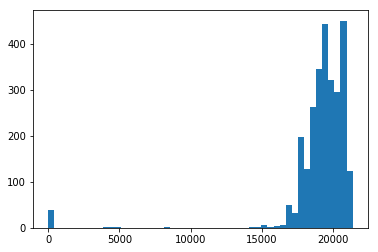

In [44]:
plt.hist(data.Main_Mass_Flow, bins = 50)

In [45]:
# this comes from fast.ai
def display_all(df):
    with pd.option_context("display.max_rows", 100, "display.max_columns", 100): 
        display(df)

Okay, some chemical engineering concepts...

There are processes that are dynamic that fluctuate a lot, and ones that achieve a "steady-state" (SS). A SS process can be assumed to more or less have the same values for all of its process parameters throughout a stretch of time, and this tends to simplify the analysis. 

In our problem, it's important to remember that we have looked back in time to pull the appropriate sensor measurement for when the molecule would have experienced this individual process parameter. In very concrete terms, whatever the measurement for the main mass flow shows, is the rate at which it was being fed into the process. Therefore, we can really say that any measurement of zero doesn't make sense and needs special treatment.

Additionally, because chemical processes are normally operated in steady state conditions, we expect to see most of our process parameters hover around some consistent values- see the main peak(s) in this histogram. Anything outside of this main distribution would probably be startup or shutdown, both cases where SS assumptions are violated. While it may make our models more robust to all possible situation to include these non-SS data points, we must ask ourselves the question if including them in our analysis is worthwhile. Typical operations would want to avoid these conditions, so is the ability to predict here (potentially at the cost of worsening our predictive abilities at normal operating conditions) worth it?

Now a look into the `Quality`, which is the overall outcome we are trying to model...

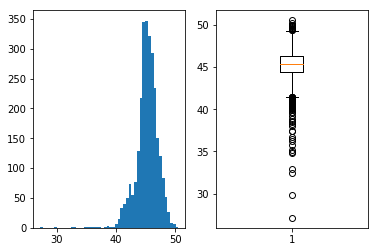

In [46]:
# take a look at our output variable
plt.subplot(1, 2, 1)
plt.hist(data.Quality, bins = 50)

plt.subplot(1, 2, 2)
plt.boxplot(data.Quality)
plt.show()

Okay in general, it looks like we have a normal-ish distributed outcome variable with a slight left skew. It could be possible that we have two normal distributions added together here, with a smaller one centered around 43 and the larger centered around 45. There appear to be some low outliers.

The data here looks like they make intuitive sense... Operations will tend to try to keep the quality near a certain expected outcome. The interesting part is really how the sensors (process parameters) can be manipulated to acheive this result, and that's our overall machine learning problem.

At this point, an important thing to realize is that nothing happens in a vaccuum. There are slight raw material fluctuations, changes in ambient temperature and humidity (weather), other process parameters that might not be measured that could effect things. Simply put, shit happens and this is why physical models can break down and not be so effective. Our goal with this model is to provide a model that is flexible and that can be used for constant prediction of how to achieve more ideal quality outcomes (ex: I want a quality of 45, I know that I need to run my process with a mass flow rate of 19,500... what other settings should I manipulate to get to that 45). 

In [47]:
display_all(data.describe().T)

,count,mean,std,min,25%,50%,75%,max
Main_Mass_Flow,2709.0,19168.710275,2607.298581,0.00,18741.343750,19285.621094,20285.824219,21387.343750
Additive_1_Ratio,2709.0,0.000682,0.000029,0.00,0.000694,0.000694,0.000694,0.000694
Additive_2_Ratio,2709.0,0.070223,0.010099,0.00,0.064253,0.070000,0.075882,0.114304
Additive_3_Ratio,2709.0,0.000887,0.000039,0.00,0.000876,0.000876,0.000876,0.001000
Additive_4_Ratio,2709.0,0.002099,0.000529,0.00,0.001886,0.002000,0.002000,0.003500
Additive_5_Ratio,2709.0,0.000943,0.000034,0.00,0.000910,0.000971,0.000971,0.000971
Additive_6_Ratio,2709.0,0.004787,0.001489,0.00,0.005250,0.005250,0.005250,0.005250
Flow_Gas_Ratio,2709.0,3.010484,0.236815,0.00,2.991348,3.001231,3.015616,4.474757
T_Zone_1,2709.0,151.532175,82.796166,0.00,190.621689,197.830124,198.116196,202.513199
T_Zone_2,2709.0,188.502639,9.809227,0.00,188.349380,189.502243,190.322769,209.051956


A few interesting things to see here...

* The minimum of everything except quality is zero. This is kinda problematic, since we have already gone back to retrieve the appropriate sensor data for each sensor. We should look and see where these values are zero for each sensor. If there's a particular row that has mostly zero values, we should consider just removing it from out analysis entirely because we can't really say what was happening there.
* The standard deviation for `T_Zone_1` is way higher than the rest. This definitely needs looking into.

In [48]:
for column in data.columns:
    series_obj = data[column]
    zeros_obj = np.where(series_obj == 0)[0]
    print(column)
    print(zeros_obj)

Main_Mass_Flow
[ 207  208  335  338  344  345  346  349  350 1071 1807 2119 2120 2390
 2391 2459 2460 2461 2462]
Additive_1_Ratio
[338]
Additive_2_Ratio
[338]
Additive_3_Ratio
[338]
Additive_4_Ratio
[338]
Additive_5_Ratio
[338]
Additive_6_Ratio
[209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262
 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280
 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316
 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334
 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352
 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370
 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388
 389 390 391 392 393 394 

A lot to see here in terms of the zero values. 
* `Main_Mass_Flow` has a few zero values. These will need to get dealt with. I'll probably just end up dropping these.
* For the additives, it appears that row 338 has all of them set to zero for some reason. If we exclude this row from our dataset, then we should be ok moving forward. This is also seen with `Flow_Gas_Ratio`
* `Additive_6` appears to be set to zero for a while. This could be a design choice or it could have been that we were getting faulty readings a lot. Because they're all consecutive, this appears to be isolated to a single campaign. Without more details it is impossible to determine if this was intentional or not... I will make the design choice to assume that this was intentional. If we chose otherwise, we might look at replacing it with the mean or median or something like that.
* `T_Zone_1` appears to have a lot of zero measurements as well, and most are consecutive. With some process knowledge, I would assume that this is from faulty sensor measurements since this cannot really be skipped in terms of the production process. We will replace these values with the mean or median.
* The rest of the temperatures have issues with 337 and 2533... we can likely get rid of these with little consequence
* `Blending` has a lot of zero values. I will operate under the assumption that this is faulty measurements and that we should replace this value. Probably will go with the mode since there are few discreet values

We've been checking for zeros, but we should also do our due dilligence and check for NA values.

In [49]:
# note... this is kinda nice, gives us type of functionality like R lapply()
for column in data.columns:
    series_obj = data[column]
    nan_obj = np.where(np.isnan(series_obj))[0]
    print(column)
    print(nan_obj)

Main_Mass_Flow
[]
Additive_1_Ratio
[]
Additive_2_Ratio
[]
Additive_3_Ratio
[]
Additive_4_Ratio
[]
Additive_5_Ratio
[]
Additive_6_Ratio
[]
Flow_Gas_Ratio
[]
T_Zone_1
[]
T_Zone_2
[]
T_Zone_3
[]
T_Zone_4
[]
T_Zone_5
[]
T_Zone_6
[]
T_Zone_7
[]
T_Zone_8
[]
T_Zone_9
[]
T_Zone_10
[]
Blending
[]
Quality
[]


Great. So we aren't dealing with missing values, just values where we have to be skeptical about the actual reading being correct. Let's investigate into `T_Zone_1` since it had that really high standard deviation. I would presume this is because of all the zero values included.

(array([6.140e+02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.400e+01, 9.000e+01,
        1.687e+03, 2.630e+02]),
 array([  0.        ,   4.05026398,   8.10052795,  12.15079193,
         16.20105591,  20.25131989,  24.30158386,  28.35184784,
         32.40211182,  36.45237579,  40.50263977,  44.55290375,
         48.60316772,  52.6534317 ,  56.70369568,  60.75395966,
         64.80422363,  68.85448761,  72.90475159,  76.95501556,
         81.00527954,  85.05554352,  89.1058075 ,  93.15

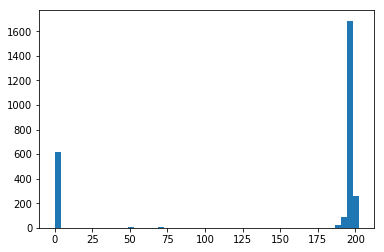

In [50]:
plt.hist(data.T_Zone_1, bins = 50)

{'boxes': [<matplotlib.lines.Line2D at 0x26b960e65c0>],
 'caps': [<matplotlib.lines.Line2D at 0x26b960e6fd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x26b960ecc88>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x26b960ec860>],
 'whiskers': [<matplotlib.lines.Line2D at 0x26b960e6710>,
  <matplotlib.lines.Line2D at 0x26b960e6ba8>]}

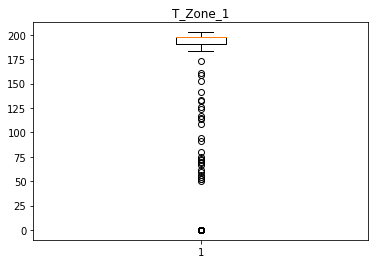

In [51]:
fig1, ax1 = plt.subplots()
ax1.set_title('T_Zone_1')
ax1.boxplot(data.T_Zone_1)

It seems like the data is super skewed to the point where the boxplot can't really show us the useful distribution. Let's start by first getting rid of the rows that we specified above. Then we can give individual column-by-column treatments where we need.

In [52]:
rows_to_delete = np.where(data.Main_Mass_Flow == 0)[0]
# also add 337, 2533

rows_to_delete = np.sort(np.concatenate((rows_to_delete, np.array([337, 2533])), axis = 0))
data.drop(rows_to_delete, axis = 0, inplace = True)
display_all(data.describe().T)

,count,mean,std,min,25%,50%,75%,max
Main_Mass_Flow,2688.0,19311.495332,2023.790622,6.436528e-38,18744.857422,19303.587891,20287.151855,21387.343750
Additive_1_Ratio,2688.0,0.000683,0.000026,6.213000e-04,0.000694,0.000694,0.000694,0.000694
Additive_2_Ratio,2688.0,0.070230,0.009975,3.739130e-02,0.064253,0.070000,0.075882,0.114304
Additive_3_Ratio,2688.0,0.000887,0.000035,8.760000e-04,0.000876,0.000876,0.000876,0.001000
Additive_4_Ratio,2688.0,0.002097,0.000527,1.000000e-03,0.001886,0.002000,0.002000,0.003500
Additive_5_Ratio,2688.0,0.000943,0.000029,9.100000e-04,0.000910,0.000971,0.000971,0.000971
Additive_6_Ratio,2688.0,0.004799,0.001472,0.000000e+00,0.005250,0.005250,0.005250,0.005250
Flow_Gas_Ratio,2688.0,3.012797,0.222761,1.116118e-02,2.991386,3.001279,3.015618,4.474757
T_Zone_1,2688.0,151.875031,82.853395,0.000000e+00,190.770550,197.832680,198.117702,202.513199
T_Zone_2,2688.0,189.018894,6.059070,7.140742e+01,188.369713,189.508362,190.324326,209.051956


In [53]:
# change T_Zone_1 zero vals
new_zero_val_T = np.median(data.T_Zone_1.iloc[np.where(data.T_Zone_1 > 50)])
data.T_Zone_1.iloc[np.where(data.T_Zone_1 <= 50)] = new_zero_val_T

# change Blending vals
new_zero_val_B = np.median(data.Blending.iloc[np.where(data.Blending > 20)])
data.Blending.iloc[np.where(data.Blending <= 20)] = new_zero_val_B

display_all(data.describe().T)

,count,mean,std,min,25%,50%,75%,max
Main_Mass_Flow,2688.0,19311.495332,2023.790622,6.436528e-38,18744.857422,19303.587891,20287.151855,21387.343750
Additive_1_Ratio,2688.0,0.000683,0.000026,6.213000e-04,0.000694,0.000694,0.000694,0.000694
Additive_2_Ratio,2688.0,0.070230,0.009975,3.739130e-02,0.064253,0.070000,0.075882,0.114304
Additive_3_Ratio,2688.0,0.000887,0.000035,8.760000e-04,0.000876,0.000876,0.000876,0.001000
Additive_4_Ratio,2688.0,0.002097,0.000527,1.000000e-03,0.001886,0.002000,0.002000,0.003500
Additive_5_Ratio,2688.0,0.000943,0.000029,9.100000e-04,0.000910,0.000971,0.000971,0.000971
Additive_6_Ratio,2688.0,0.004799,0.001472,0.000000e+00,0.005250,0.005250,0.005250,0.005250
Flow_Gas_Ratio,2688.0,3.012797,0.222761,1.116118e-02,2.991386,3.001279,3.015618,4.474757
T_Zone_1,2688.0,196.950803,7.915550,5.051351e+01,197.779972,197.979858,198.117702,202.513199
T_Zone_2,2688.0,189.018894,6.059070,7.140742e+01,188.369713,189.508362,190.324326,209.051956


Okay so notice how the `Main_Mass_Flow` minimum is a super low number, but not zero. A practical note... Normal operations wouldn't really have a main mass flow below 15000. We're going to cut out any values below here. This design choice will intentionally make us a little worse at predicting non-SS conditions but makes our modeling problem simpler.

In [54]:
np.where(data.Main_Mass_Flow < 15000)

(array([  85,  153,  333,  340,  437,  438,  444,  525,  843,  844,  924,
        1060, 1434, 1663, 1664, 1665, 1795, 1796, 1848, 1849, 1850, 1851,
        1995, 1996, 2443], dtype=int64),)

There's only like 20 or so rows.. we can drop these without a ton of consequence

In [55]:
data = data[data.Main_Mass_Flow > 15000]
display_all(data.describe().T)

,count,mean,std,min,25%,50%,75%,max
Main_Mass_Flow,2663.0,19473.880200,1063.280144,15063.688477,18759.059570,19485.019531,20289.381836,21387.343750
Additive_1_Ratio,2663.0,0.000683,0.000026,0.000621,0.000694,0.000694,0.000694,0.000694
Additive_2_Ratio,2663.0,0.070199,0.009967,0.037391,0.064253,0.070000,0.075882,0.114304
Additive_3_Ratio,2663.0,0.000887,0.000035,0.000876,0.000876,0.000876,0.000876,0.001000
Additive_4_Ratio,2663.0,0.002097,0.000527,0.001000,0.001886,0.002000,0.002000,0.003500
Additive_5_Ratio,2663.0,0.000943,0.000029,0.000910,0.000910,0.000971,0.000971,0.000971
Additive_6_Ratio,2663.0,0.004801,0.001469,0.000000,0.005250,0.005250,0.005250,0.005250
Flow_Gas_Ratio,2663.0,3.013906,0.214915,2.284886,2.991385,3.001272,3.015617,4.474757
T_Zone_1,2663.0,197.482703,1.636473,186.761017,197.794159,197.979858,198.118370,201.257904
T_Zone_2,2663.0,189.363981,1.440237,161.497040,188.386131,189.511215,190.323730,202.035049


In [56]:
data.shape

(2663, 20)

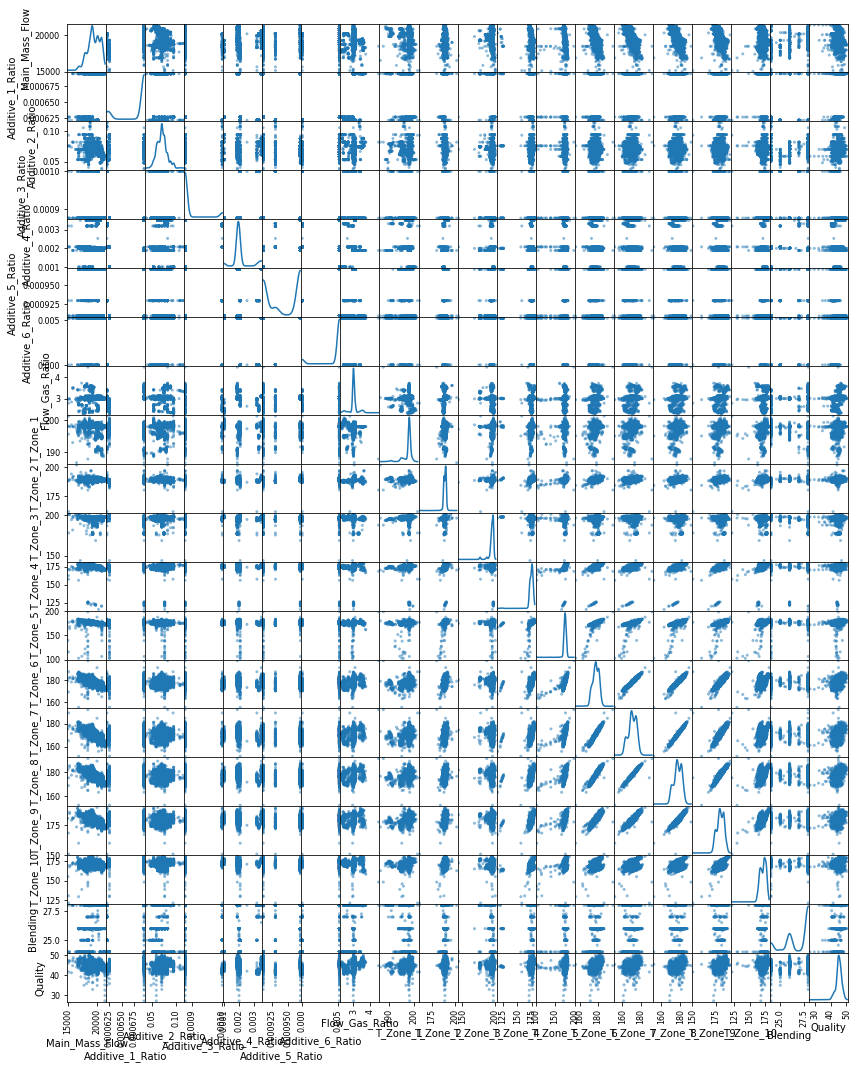

In [57]:
grr = pd.plotting.scatter_matrix(data, figsize = (14,18), diagonal = 'kde')

At this point, I think we're doing pretty well in terms of having manipulated our data for overall quality concerns. We note that there's nothing that really has a direct linear correlation with our `Quality` variable. A lot of the temperature variables are correlated with each other in direct linear fashion, which kinda makes sense. The heat from one zone would likely "spill over" to another, even though they're controlled independently.

So now let's think about what features we might want to engineer. A few things I can think of:
* As we move to a new temperature zone, is this higher or lower than where we have come from? For example, T1 > T2? This is a binary feature that we could do for each transition.
* Average temperature across different zones... For example, average of first 3, average of next 3, average of last 4
* One-hot-encoding some of the variables that don't change so much or that have few discrete values, such as blending
* Scaling and centering for broader general use with whatever algorithm we might want to use
* Interaction terms for different chemical ratios (not going to be implemented here)

In [58]:
# procedure for generating cols for binary temperature increase
for i in range(1,10):
    new_colname = "T_Increase_" + str(i)
    colname_i = "T_Zone_" + str(i)
    colname_inext = "T_Zone_" + str(i+1)
    vals = (data[colname_i] <= data[colname_inext]).astype(int)
    data[new_colname] = vals

In [59]:
display_all(data.describe().T)

,count,mean,std,min,25%,50%,75%,max
Main_Mass_Flow,2663.0,19473.880200,1063.280144,15063.688477,18759.059570,19485.019531,20289.381836,21387.343750
Additive_1_Ratio,2663.0,0.000683,0.000026,0.000621,0.000694,0.000694,0.000694,0.000694
Additive_2_Ratio,2663.0,0.070199,0.009967,0.037391,0.064253,0.070000,0.075882,0.114304
Additive_3_Ratio,2663.0,0.000887,0.000035,0.000876,0.000876,0.000876,0.000876,0.001000
Additive_4_Ratio,2663.0,0.002097,0.000527,0.001000,0.001886,0.002000,0.002000,0.003500
Additive_5_Ratio,2663.0,0.000943,0.000029,0.000910,0.000910,0.000971,0.000971,0.000971
Additive_6_Ratio,2663.0,0.004801,0.001469,0.000000,0.005250,0.005250,0.005250,0.005250
Flow_Gas_Ratio,2663.0,3.013906,0.214915,2.284886,2.991385,3.001272,3.015617,4.474757
T_Zone_1,2663.0,197.482703,1.636473,186.761017,197.794159,197.979858,198.118370,201.257904
T_Zone_2,2663.0,189.363981,1.440237,161.497040,188.386131,189.511215,190.323730,202.035049


In [60]:
# code for generating averages...
# this is not really applicable with just doing an initial linear model since this will be linearly dependent
# will throw us an error or be tossed out anyways for a rank-deficient matrix

In [61]:
# code for one-hot encoding blending
# may be useful for some ratios, need to look into this later
data.Blending.unique()
# actually there's enough here that we can probably leave as-is

array([24.        , 25.        , 28.        , 27.        , 27.10778999,
       27.9840374 , 27.54655647, 27.25042725, 27.06365585, 27.03421021,
       27.92428589, 27.01937675, 27.27140617, 27.96147156, 27.07689667,
       26.52480698, 26.68097878, 26.        , 24.57772827, 25.81062698,
       25.3692894 , 25.47265053, 25.57063293, 25.01825333, 25.97343254,
       25.26783752])

In [62]:
from sklearn.preprocessing import StandardScaler
# scale all the non-binary features
scaled_colnames = data.columns[0:18]
scaled_features = data.copy()
features = scaled_features[scaled_colnames]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features[scaled_colnames] = features

In [63]:
display_all(scaled_features.describe().T)

,count,mean,std,min,25%,50%,75%,max
Main_Mass_Flow,2663.0,1.051106e-15,1.000188,-4.148502,-0.672405,0.010478,0.767112,1.799924
Additive_1_Ratio,2663.0,-1.484251e-14,1.000188,-2.357615,0.440326,0.440326,0.440326,0.440326
Additive_2_Ratio,2663.0,2.566812e-15,1.000188,-3.292103,-0.596667,-0.019969,0.570298,4.425715
Additive_3_Ratio,2663.0,5.325110e-15,1.000188,-0.305998,-0.305998,-0.305998,-0.305998,3.268000
Additive_4_Ratio,2663.0,1.212782e-15,1.000188,-2.082590,-0.400528,-0.184100,-0.184100,2.663635
Additive_5_Ratio,2663.0,9.786556e-15,1.000188,-1.129761,-1.129761,0.958063,0.958063,0.958063
Additive_6_Ratio,2663.0,-3.559884e-15,1.000188,-3.268000,0.305998,0.305998,0.305998,0.305998
Flow_Gas_Ratio,2663.0,-8.264866e-16,1.000188,-3.392766,-0.104811,-0.058799,0.007960,6.798612
T_Zone_1,2663.0,-1.014751e-14,1.000188,-6.552936,0.190357,0.303854,0.388510,2.307347
T_Zone_2,2663.0,-1.086501e-14,1.000188,-19.352492,-0.679078,0.102248,0.666508,8.799558


We're finally at the stage where we can start doing the typical machine learning stuff... train/validation/test splits and such. 

While this data is not explicitly time series, we have to think about this a little bit carefully. The process will, in a certain sense, "evolve" over time as things like fouling (junk in the pipes accumulating), process knowledge increasing and therefore changes in operations knowledge... a lot of things can change over time that might not be explicitly reflected in the data. 

Here, I'd propose that the test set would be the final data points and the validation be a weighted sliding window, similar to the nested cross-validation shown here: https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9

This requires a little bit of a different setup compared to what we're done in the past. This can be seen here: https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html

In [64]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
import math

def calc_error(predicted, actual):
    return(actual - predicted)

def rmse(predicted, actual):
    return(np.sqrt(np.mean(calc_error(predicted, actual)**2)))

def mae(predicted, actual):
    return(np.mean(np.abs(calc_error(predicted, actual))))

In [65]:
y = scaled_features.Quality
scaled_features.drop(['Quality'], axis = 1, inplace = True)
X = scaled_features

# let's use 80% train/validate, 20% test... so with our setup, it will be 60/20/20
train_rows = math.ceil(0.80 * X.shape[0])
test_rows = (len(X) - train_rows)
X_train, X_test = X[0:train_rows], X[-test_rows:]
y_train, t_test = y[0:train_rows], y[-test_rows:]


Simple train/test split


In [66]:
from sklearn.model_selection import train_test_split
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
lm = LinearRegression()
fit_model = lm.fit(X_train2, y_train2)
predictions = fit_model.predict(X_valid)
print("MAE")
print(mae(predictions, y_valid))
print("")
print("RMSE")
print(rmse(predictions, y_valid))

MAE
0.9613001112763306

RMSE
1.474476453254668


In [67]:
from sklearn.metrics import mean_squared_error, r2_score
r2_score(y_valid, predictions)

0.4472377564574327

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  6.,  6., 10., 12., 25., 37., 36., 54., 55.,
        59., 39., 35., 16., 15.,  6.,  3.,  3.,  3.,  0.,  1.]),
 array([-13.30504839, -12.95750659, -12.60996479, -12.26242299,
        -11.91488119, -11.56733939, -11.21979759, -10.87225579,
        -10.52471399, -10.17717219,  -9.82963039,  -9.48208859,
         -9.13454679,  -8.78700499,  -8.43946319,  -8.09192139,
         -7.74437959,  -7.39683779,  -7.04929598,  -6.70175418,
         -6.35421238,  -6.00667058,  -5.65912878,  -5.31158698,
         -4.96404518,  -4.61650338,  -4.26896158,  -3.92141978,
         -3.57387798,  -3.22633618,  -2.87879438,  -2.53125258,
         -2.18371078,  -1.83616898,  -1.48862718,  -1.14108538,
         -0.79354358,  -0.44600178,  -0.09845998,   0.24908182,
          0.59662362,   0.94416542,   1.29170722,   1.63924902,
          1.

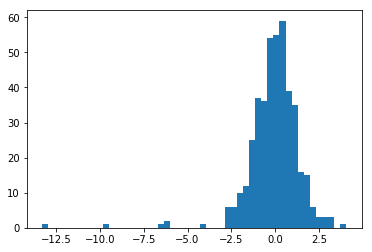

In [72]:
errors = calc_error(predictions, y_valid)
plt.hist(errors, bins = 50)

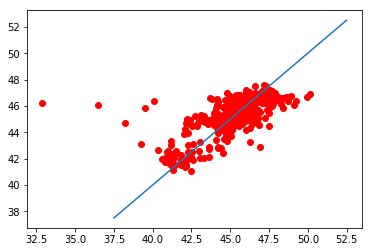

In [73]:
plt.scatter(x = y_valid, y = predictions, c = "red")
plt.plot(np.linspace(37.5, 52.5, 50), np.linspace(37.5,52.5,50))
plt.show()

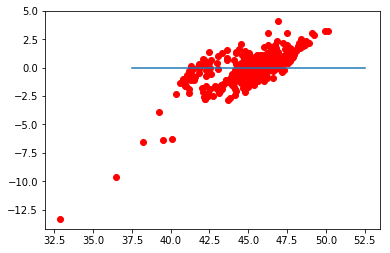

In [74]:
plt.scatter(x = y_valid, y = errors, c = "red")
plt.plot(np.linspace(37.5, 52.5, 50), np.zeros(50))

Try without scaling...

In [68]:
Xd = data.copy()
yd = Xd.Quality
Xd.drop(['Quality'], axis = 1, inplace = True)


# let's use 80% train/validate, 20% test... so with our setup, it will be 60/20/20
train_rows = math.ceil(0.80 * Xd.shape[0])
test_rows = (len(Xd) - train_rows)
Xd_train, Xd_test = Xd[0:train_rows], Xd[-test_rows:]
yd_train, yd_test = yd[0:train_rows], yd[-test_rows:]

In [69]:
Xd_train2, Xd_valid, yd_train2, yd_valid = train_test_split(Xd_train, yd_train, test_size=0.2, random_state=42)

In [70]:
lm = LinearRegression()
fit_model = lm.fit(Xd_train2, yd_train2)
pred_vd = fit_model.predict(Xd_valid)

In [71]:
print("Mean squared error: %.2f"
      % mean_squared_error(yd_valid, pred_vd))
print('R-squared: %.2f'
      % r2_score(yd_valid, pred_vd))

Mean squared error: 2.17
R-squared: 0.45


In [75]:
# from Hong.. thoughts about anamoly detection

## Anomaly Detection

Assume a set of data {$X_{0}$, $X_{1}$, ..., $X_{n}$}

for loop each element of data:

    assume $X_{k}$ is current selection
    
    calculate mean and std of all others.
    
    if $X_{k}$ -mean> 3 * std, then it's a outlier
